Libraries

In [ ]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from PIL import Image
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

Checking device (GPU or CPU)

In [3]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:",device)

Using device: cpu


Load the dataset

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(r"D:\cell_images", transform=transform)
classes = dataset.classes
print("Classes: ", classes)

Classes:  ['Parasitized', 'Uninfected']


Spliting the dataset into training and testing

In [5]:
train = int(0.7 * len(dataset))
val = int(0.1 * len(dataset))
test = len(dataset) - (train + val)
trainDataset, valDataset, testDataset = random_split(dataset, [train, val, test])

trainLoader = DataLoader(trainDataset, batch_size=512, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=512, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=512, shuffle=False)

print(f"Dataset Split:- Train: {len(trainDataset)}, Validate: {len(valDataset)}, Test: {len(testDataset)}")

Dataset Split:- Train: 19290, Validate: 2755, Test: 5513


For experimenting 

In [6]:
# torch.manual_seed(42)

# train = int(0.1 * len(dataset))
# val = int(0.05 * len(dataset))
# test = int(0.05 * len(dataset)) 
# extra = len(dataset) - (train + val + test)

# trainDataset, valDataset, testDataset, _ = random_split(dataset, [train, val, test, extra])

# trainLoader = DataLoader(trainDataset, batch_size=256, shuffle=True)
# valLoader = DataLoader(valDataset, batch_size=256, shuffle=False)
# testLoader = DataLoader(testDataset, batch_size=256, shuffle=False)

# print(f"Dataset Split:- Train: {len(trainDataset)}, Validate: {len(valDataset)}, Test: {len(testDataset)}")

Visualizing Image

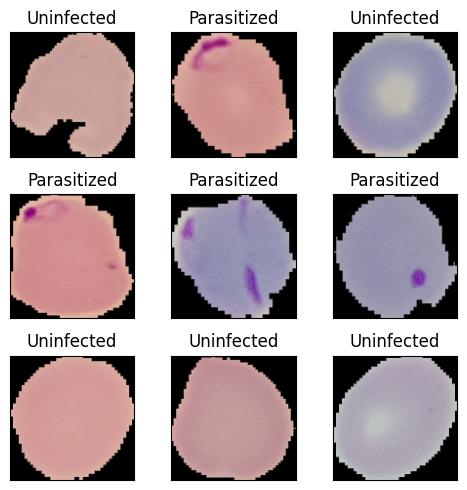

In [7]:
images, labels = next(iter(trainLoader))
plt.figure(figsize=(5,5))

for i in range(9):
    img = images[i].permute(1,2,0)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = torch.clamp(img, 0, 1)
    plt.subplot(3, 3, i+1, xticks=[], yticks=[])
    plt.imshow(img)
    plt.title(classes[labels[i]])

plt.tight_layout()
plt.show()

Defining a CNN model with multiple Normalizations

In [8]:
class simpleCNN(nn.Module):
    def __init__(self, numClasses=2):
        super(simpleCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.LayerNorm([32,64,64]),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.GroupNorm(8, 128),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128*8*8, numClasses)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

model = simpleCNN(numClasses=len(classes)).to(device)
print(model)

simpleCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LayerNorm((32, 64, 64), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm(8, 128, ep

Training Setup

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
numEpochs = 25

In [10]:
trainLosses = []
valLosses = []
valAccuracies = []

for epoch in range(numEpochs):
    model.train()
    totalLoss = 0

    for inputs, labels in trainLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()              # reset gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()                    # backpropagation
        optimizer.step()                   # update weights
        totalLoss += loss.item()

    avgTrainLoss = totalLoss / len(trainLoader)
    trainLosses.append(avgTrainLoss)
    print(f"Epoch [{epoch+1}/{numEpochs}], Loss: {avgTrainLoss: .4f}")

    # Validation accuracy after each epoch
    model.eval()
    valLoss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in valLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valLoss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avgValLoss = valLoss / len(valLoader)
    valLosses.append(avgValLoss)
    valAcc = 100 * correct / total
    valAccuracies.append(valAcc)
    
    print(f"Validation Accuracy: {valAcc: .2f}%")

Epoch [1/25], Loss:  1.1851
Validation Accuracy:  64.50%
Epoch [2/25], Loss:  0.4581
Validation Accuracy:  90.49%
Epoch [3/25], Loss:  0.1681
Validation Accuracy:  95.14%
Epoch [4/25], Loss:  0.1344
Validation Accuracy:  95.97%
Epoch [5/25], Loss:  0.1193
Validation Accuracy:  96.33%
Epoch [6/25], Loss:  0.1148
Validation Accuracy:  96.23%
Epoch [7/25], Loss:  0.1070
Validation Accuracy:  96.41%
Epoch [8/25], Loss:  0.1036
Validation Accuracy:  96.33%
Epoch [9/25], Loss:  0.0953
Validation Accuracy:  96.44%
Epoch [10/25], Loss:  0.0900
Validation Accuracy:  96.04%
Epoch [11/25], Loss:  0.0847
Validation Accuracy:  96.44%
Epoch [12/25], Loss:  0.0755
Validation Accuracy:  95.21%
Epoch [13/25], Loss:  0.0730
Validation Accuracy:  96.73%
Epoch [14/25], Loss:  0.0596
Validation Accuracy:  96.44%
Epoch [15/25], Loss:  0.0601
Validation Accuracy:  95.68%
Epoch [16/25], Loss:  0.0553
Validation Accuracy:  96.41%
Epoch [17/25], Loss:  0.0336
Validation Accuracy:  96.44%
Epoch [18/25], Loss:  0

Ploting training and validation performance

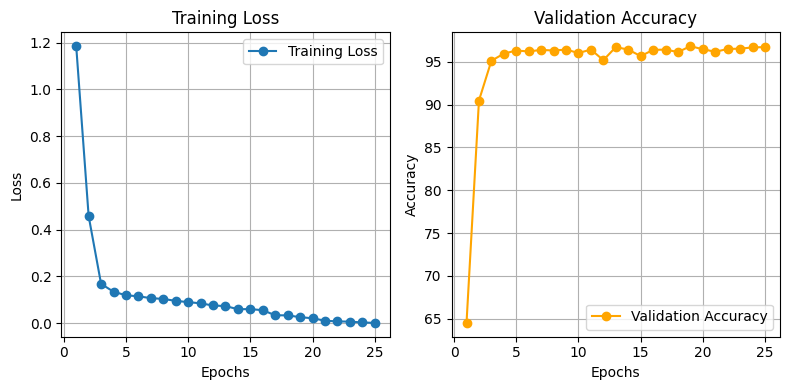

In [12]:
plt.figure(figsize=(8,4))

numEpochs = 25
plt.subplot(1,2,1)
plt.plot(range(1, numEpochs+1), trainLosses, marker='o', label='Training Loss')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, numEpochs+1), valAccuracies, marker='o', color='orange', label= 'Validation Accuracy')
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

Testing the model

In [13]:
model.eval()
yTrue, yPredict = [], []

with torch.no_grad():
    for inputs, labels in testLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        yTrue.extend(labels.cpu().numpy())
        yPredict.extend(predicted.cpu().numpy())

testAccuracy = accuracy_score(yTrue, yPredict) * 100
print(f"Final Test Accuracy: {testAccuracy:.2f}%")

Final Test Accuracy: 96.03%


Confusion Matrix

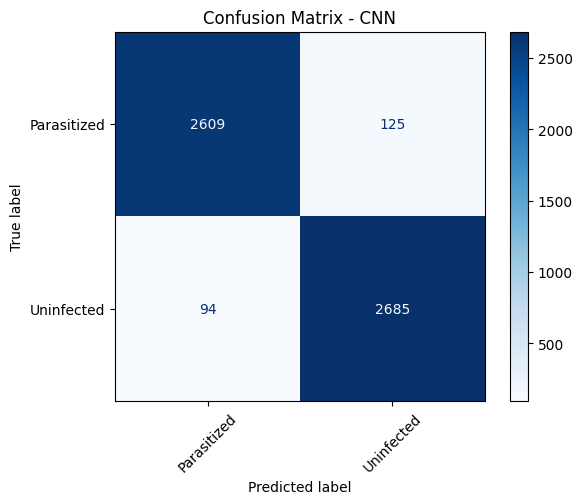

In [24]:
cm = confusion_matrix(yTrue, yPredict)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
display.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - CNN")
plt.show()

Prediction

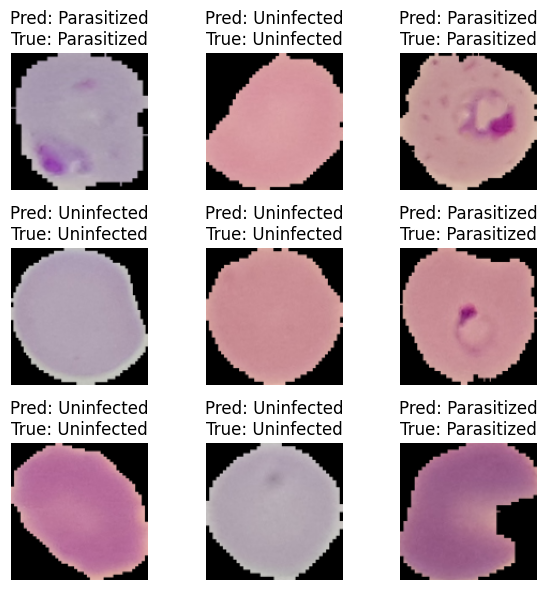

In [15]:
images, labels = next(iter(testLoader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(6,6))
for i in range(9):
    img = images[i].cpu().permute(1,2,0)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = torch.clamp(img, 0, 1)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Extracting Features for Classifiers

In [16]:
def extractFeatures(model, dataLoader):
    model.eval()
    features, labelsList = [], []
    with torch.no_grad():
        for inputs, labels in dataLoader:
            inputs = inputs.to(device)
            x = model.layer1(inputs)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)
            x = torch.flatten(x, start_dim=1)
            features.append(x.cpu().numpy())
            labelsList.append(labels.numpy())
    
    return np.concatenate(features), np.concatenate(labelsList)

In [17]:
print("Extracting features from CNN...")
trainFeatures, trainLabels = extractFeatures(model, trainLoader)
testFeatures, testLabels = extractFeatures(model, testLoader)

Extracting features from CNN...


In [18]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": SVC(kernel='linear', probability=True),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=20, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

In [19]:
results = {}
for name, clf in classifiers.items():
    print(f"\nTraining {name}")

    clf.fit(trainFeatures, trainLabels)
    preds = clf.predict(testFeatures)
    acc = accuracy_score(testLabels, preds) * 100
    results[name] = acc

    print(f"{name} Accuracy: {acc:.2f}%")


Training Logistic Regression
Logistic Regression Accuracy: 95.88%

Training SVM
SVM Accuracy: 95.90%

Training Decision Tree
Decision Tree Accuracy: 94.59%

Training Random Forest
Random Forest Accuracy: 96.01%

Training KNN
KNN Accuracy: 96.12%

Training Naive Bayes
Naive Bayes Accuracy: 95.32%


Confusion matrix for Best classifier

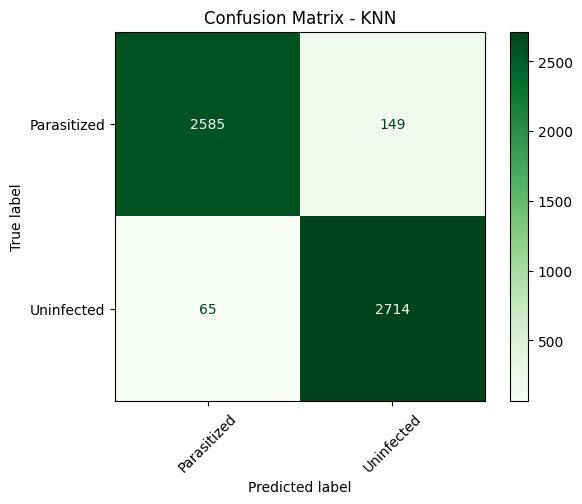

In [20]:
best_clf_name = max(results, key=results.get)
best_clf = classifiers[best_clf_name]
y_pred_best = best_clf.predict(testFeatures)
cm_best = confusion_matrix(testLabels, y_pred_best)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=classes)
disp_best.plot(cmap='Greens', xticks_rotation=45)
plt.title(f"Confusion Matrix - {best_clf_name}")
plt.show()

Final Testing Summary

In [21]:
cnn_val_acc = valAccuracies[-1]
results["CNN Model (Validation)"] = cnn_val_acc
results["CNN Model (Test)"] = testAccuracy

summary_df = pd.DataFrame(list(results.items()), columns=["Model", "Test Accuracy (%)"])
summary_df = summary_df.sort_values(by="Test Accuracy (%)", ascending=False).reset_index(drop=True)

print("\n Final Model Performance Comparison:")
print(summary_df.to_string(index=False))


 Final Model Performance Comparison:
                 Model  Test Accuracy (%)
CNN Model (Validation)          96.733212
                   KNN          96.118266
      CNN Model (Test)          96.027571
         Random Forest          96.009432
                   SVM          95.900599
   Logistic Regression          95.882460
           Naive Bayes          95.320152
         Decision Tree          94.594595


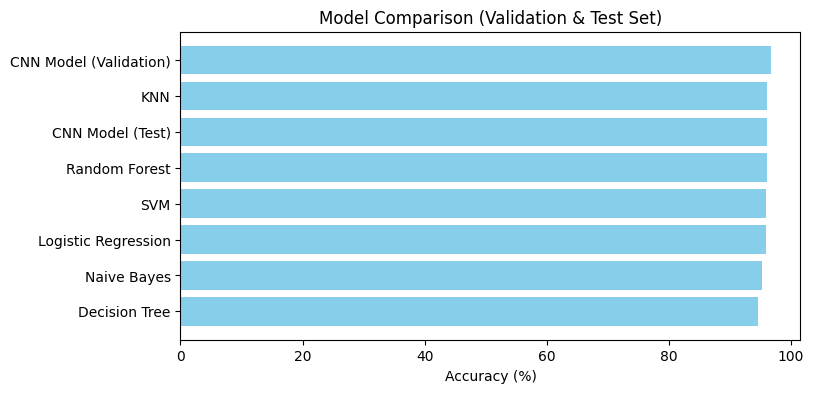

In [22]:
plt.figure(figsize=(8, 4))
plt.barh(summary_df["Model"], summary_df["Test Accuracy (%)"], color='skyblue')
plt.xlabel("Accuracy (%)")
plt.title("Model Comparison (Validation & Test Set)")
plt.gca().invert_yaxis()
plt.show()

In [23]:
best_model = summary_df.iloc[0]
print(f"\nBest Performing Model: {best_model['Model']}")
print(f"Accuracy: {best_model['Test Accuracy (%)']:.2f}%")

summary_df.to_csv("model_comparison_results.csv", index=False)
print("\nResults saved to 'model_comparison_results.csv'")


Best Performing Model: CNN Model (Validation)
Accuracy: 96.73%

Results saved to 'model_comparison_results.csv'
